In [2]:
import autograd.numpy as anp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
import tidy3d as td
from autograd import value_and_grad
from tidy3d.plugins.autograd.invdes import (
    get_kernel_size_px,
    make_filter,
    tanh_projection,
    make_erosion_dilation_penalty,
    grey_indicator,
)
from tidy3d.web import run
from mode_converter import make_simulation

In [3]:
def get_mode_power(sim_data: td.SimulationData, *, mode_index: int = 2) -> float:
    output_amps = sim_data["mode_monitor"].amps
    amp = output_amps.sel(direction="+", mode_index=mode_index).isel(f=0).values
    power = anp.sum(anp.abs(amp) ** 2)
    return power

In [4]:
rng = np.random.default_rng(294587)

sx = 3
sy = 2
dl = 0.01
filter_radius = 0.1
beta = 20

# x0 = rng.uniform(0.45, 0.55, (int(sx / dl), int(sy / dl)))
x0 = np.zeros((int(sx / dl), int(sy / dl)))
x0[:, : x0.shape[1] // 2] = 0.51
x0[:, x0.shape[1] // 2 :] = 0.49
lb = np.zeros_like(x0)
ub = np.ones_like(x0)

kernel_size = get_kernel_size_px(filter_radius, dl)
filter_fn = make_filter("conic", kernel_size)
ed_penalty = make_erosion_dilation_penalty(kernel_size)


def parametrization(x, beta=beta, eta=0.5):
    x = filter_fn(x)
    x = tanh_projection(x, beta, eta)
    return x


def objective(x):
    x = parametrization(x)
    # penalty = ed_penalty(x)
    penalty = grey_indicator(x)
    sim = make_simulation(x, design_dl=dl)
    sim_data = run(sim, task_name="invdes", verbose=False)
    mode_power = get_mode_power(sim_data)
    return mode_power - penalty


vg_fun = value_and_grad(objective)

cnt = iter(range(100))


def nlopt_obj(x, gd):
    x = np.reshape(x, x0.shape)

    step = next(cnt)
    fig, ax = plt.subplots(tight_layout=True)
    ax.imshow(parametrization(x).T, cmap="gray_r", vmin=0, vmax=1)
    plt.show()
    # fig.savefig(f"step_{step:02d}.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
    plt.close(fig)

    v, g = vg_fun(x)
    print(f"{step}: {v}")
    if gd.size > 0:
        gd[:] = g.ravel()
    return v.item()


opt = nlopt.opt(nlopt.LD_MMA, x0.size)
opt.set_lower_bounds(lb.ravel())
opt.set_upper_bounds(ub.ravel())
opt.set_max_objective(nlopt_obj)
opt.set_maxeval(50)

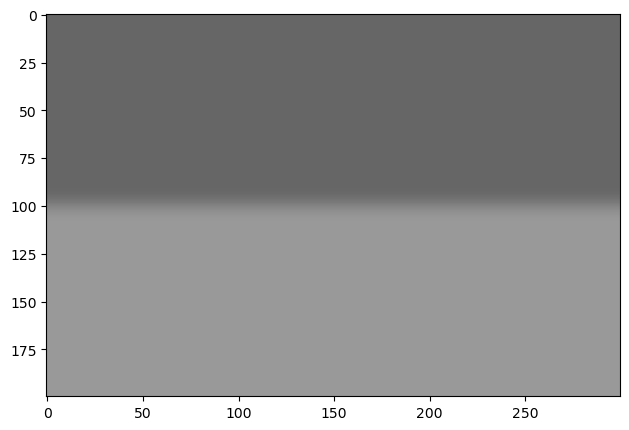

0: -0.9396560265665291


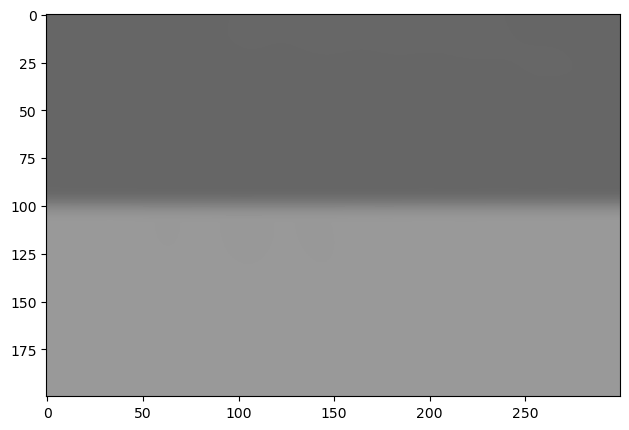

1: -0.938146328040111


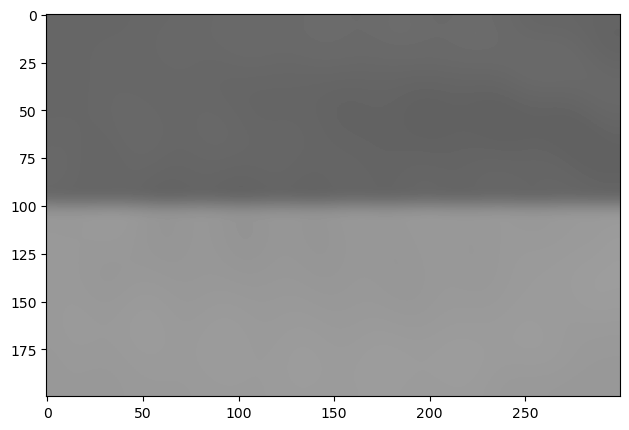

KeyboardInterrupt: 

In [5]:
xopt = opt.optimize(x0.ravel())
sim = make_simulation(np.reshape(xopt, x0.shape), design_dl=dl)